<a href="https://colab.research.google.com/github/sauravsolanki/predict-dance/blob/main/PredictDance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import random
from torch.nn import functional as F

plt.ion()   # interactive mode

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount("content")

root = "/content/content/My Drive/data/Predict Dance"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content


In [ ]:
dance_data = pd.read_csv(root + '/dataset/train.csv')
dance_data.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [ ]:
n = 0
img_name = dance_data.iloc[n, 0]
label = dance_data.iloc[n, 1]

print('Image name: {}'.format(img_name))
print('label: {}'.format(label))

Image name: 96.jpg
label: manipuri


In [ ]:
dance_data.describe()

,Image,target
count,364,364
unique,364,8
top,93.jpg,mohiniyattam
freq,1,50


In [ ]:
dance_data[:200]

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi
...,...,...
195,233.jpg,kathakali
196,134.jpg,bharatanatyam
197,197.jpg,kathakali
198,245.jpg,mohiniyattam


In [ ]:
DANCE_LIST = list(set(dance_data['target']))

y = list(dance_data["target"])

y = np.array(list(map(lambda x: DANCE_LIST.index(x), y)))

dance_data["label"] = y
dance_data.head()

,Image,target,label
0,96.jpg,manipuri,2
1,163.jpg,bharatanatyam,0
2,450.jpg,odissi,3
3,219.jpg,kathakali,7
4,455.jpg,odissi,3


In [ ]:
set(dance_data["label"])

{0, 1, 2, 3, 4, 5, 6, 7}

In [ ]:
dance_data.iloc[0,2]

2

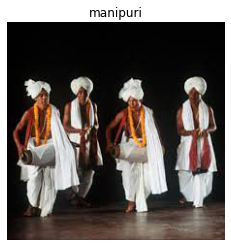

In [ ]:
def show_landmarks(image, label):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
    
plt.figure()
show_landmarks(io.imread(os.path.join(root + '/dataset/train/', img_name)),
               label)
plt.show()

In [ ]:
class DanceDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file,mode="train",transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dance_data = pd.read_csv(root + '/dataset/'+csv_file)
        if mode == "train":
            self.dance_data = self.dance_data[:300]
        elif mode == "val":
            self.dance_data = self.dance_data[300:]

        if mode !="test":  
          y = list(self.dance_data["target"])
          self.dance_data["label"] = np.array(list(map(lambda x: DANCE_LIST.index(x), y)))
          self.root_dir = root + '/dataset/train/'
        else:
          self.root_dir = root + '/dataset/%s/'%mode

        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.dance_data)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dance_data.iloc[idx, 0])
        image = io.imread(img_name)
        if self.mode != "test":
          label = self.dance_data.iloc[idx, 2]
        else:
          label = 0
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
train_datatset = DanceDataset("train.csv",mode="train",transform=None)

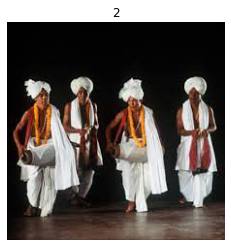

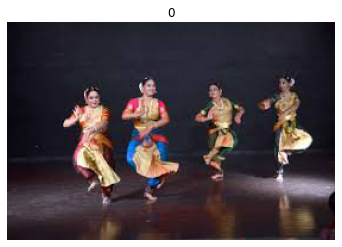

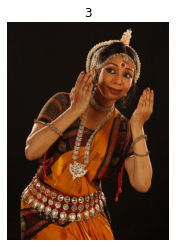

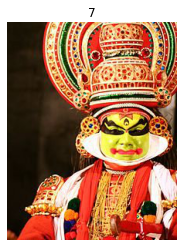

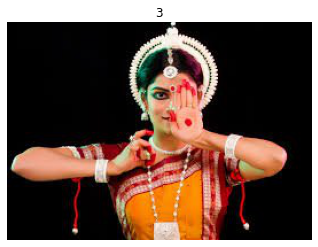

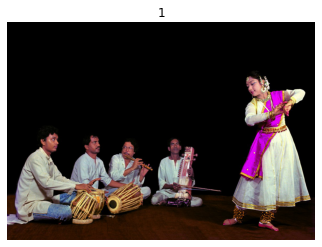

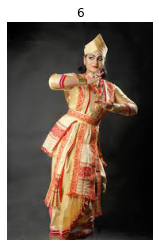

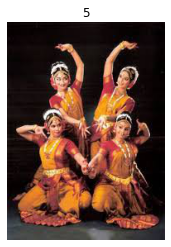

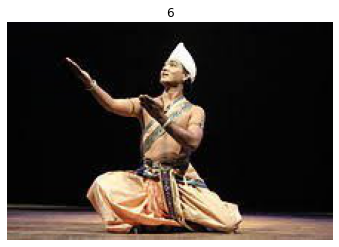

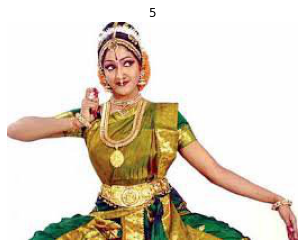

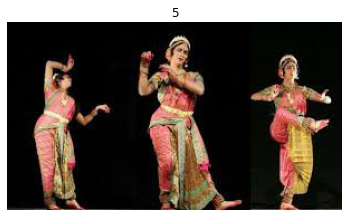

In [ ]:
for idx,sample in enumerate(train_datatset):
    plt.figure()
    show_landmarks(sample["image"],sample["label"])
    plt.show()
    if idx==10: break

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
 
        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'label': label}

class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if random.random() < self.p:
            return np.fliplr(image)

        # image = image.transpose((2, 0, 1))
        
        sample['image'] = image 
        return sample

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.tensor(label)}


TypeError: ignored

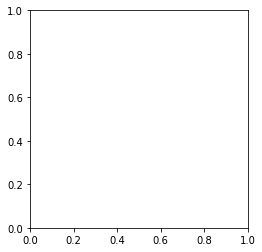

In [ ]:
train_datatset = DanceDataset("train.csv",mode="train",
                              transform = transforms.Compose([
                                               Rescale((256,256)),
                                               RandomCrop((224,224)),
                                              #  RandomVerticalFlip(),
                                               ToTensor()
                                           ]))

sample = train_datatset[65]
show_landmarks(**sample)

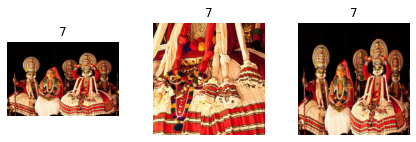

In [ ]:
scale = Rescale(256)
crop = RandomCrop(224)
composed = transforms.Compose([Rescale((256,256)),
                               RandomCrop(250)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_datatset[65]
show_landmarks(**sample)
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [ ]:
train_datatset = DanceDataset("train.csv",mode="train",
                              transform = transforms.Compose([
                                               Rescale((256,256)),
                                               RandomCrop((224,224)),
                                               ToTensor()
                                           ]))

for i in range(len(train_datatset)):
    sample = train_datatset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) tensor(2)
1 torch.Size([3, 224, 224]) tensor(0)
2 torch.Size([3, 224, 224]) tensor(3)
3 torch.Size([3, 224, 224]) tensor(7)


0 torch.Size([4, 3, 224, 224]) tensor([4, 3, 0, 7])
1 torch.Size([4, 3, 224, 224]) tensor([0, 2, 5, 5])
2 torch.Size([4, 3, 224, 224]) tensor([7, 6, 4, 0])
3 torch.Size([4, 3, 224, 224]) tensor([1, 4, 5, 6])


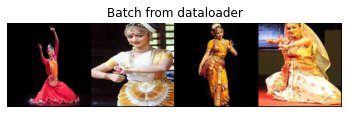

In [ ]:
dataloader = DataLoader(train_datatset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, label = sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = 0.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample in dataloaders[phase]:
                inputs, labels = sample["image"], sample["label"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.double())
                    _, preds = torch.max(outputs, 1)
                    try:
                        loss = criterion(outputs, labels)
                    except IndexError as e:
                        print(outputs, labels)
                        continue

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss > best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(DANCE_LIST[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(DANCE_LIST))

model_ft = model_ft.double()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
dataloaders= {}

train_datatset = DanceDataset("train.csv",mode="train",
                              transform = transforms.Compose([
                                               Rescale((256,256)),
                                               RandomCrop((224,224)),
                                               RandomVerticalFlip(),
                                               ToTensor()
                                           ]))
# RandomRotation
# RandomVerticalFlip
train_datatset2 = DanceDataset("train.csv",mode="train",
                              transform = transforms.Compose([
                                               Rescale((256,256)),
                                              #  transforms.center_crop((224,224)),
                                               
                                               ToTensor()
                                           ]))

val_datatset = DanceDataset("train.csv",mode="val",
                              transform = transforms.Compose([
                                               Rescale((224,224)),
                                               ToTensor()
                                           ]))


dataloaders["train"] = DataLoader(train_datatset, batch_size=16,shuffle=True, num_workers=64)
dataloaders["val"] = DataLoader(val_datatset, batch_size=8,shuffle=False, num_workers=64)

dataset_sizes={"train":len(train_datatset),"val":len(val_datatset)}

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


AttributeError: ignored

In [ ]:
print(str(criterion))

CrossEntropyLoss()


In [ ]:
epochs = 20
torch.save({
            'epoch': 20,
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'loss': criterion,
            }, root + "/saved_model/model_"+str(epochs)+str(criterion)+".pth")

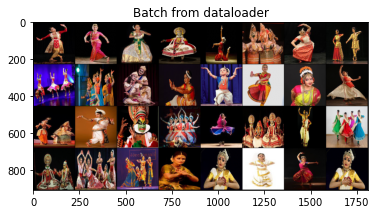

In [ ]:
test_datatset = DanceDataset("test.csv",mode="test",
                              transform = transforms.Compose([
                                               Rescale((224,224)),
                                               ToTensor()
                                           ]))

# Helper function to show a batch
test_loader = DataLoader(test_datatset, batch_size=32,shuffle=True, num_workers=64)

sample_batched = iter(test_loader).next()
show_landmarks_batch(sample_batched)


In [ ]:
model_ft.eval()
images = sample_batched["image"].to(device)
_, predicted = torch.max(model_ft(images), 1)
predicted

tensor([3, 4, 0, 3, 1, 0, 2, 2, 7, 3, 3, 0, 4, 0, 0, 3, 3, 6, 3, 6, 0, 1, 3, 0,
        6, 2, 3, 1, 5, 4, 0, 1], device='cuda:0')

In [ ]:
from sklearn.metrics import f1_score

y_true=[]
y_pred=[]

model_ft.eval()

for sample in dataloaders["train"]:
  inputs, labels = sample["image"], sample["label"]
  y_true.extend(labels.numpy().flatten())
  inputs = inputs.to(device)
  labels = labels.to(device)
  # forward
  # track history if only in train
  with torch.set_grad_enabled(False):
    outputs = model_ft(inputs.double())
    _, preds = torch.max(outputs, 1)
    y_pred.extend(preds.cpu().numpy().flatten())


print(np.sum(np.array(y_true) == np.array(y_pred)))
print(f1_score(y_true, y_pred, average='weighted'))

300
1.0


In [ ]:
#for submission
model_ft.eval()
test_predict = []
for sample in test_loader:
  inputs, labels = sample["image"], sample["label"]
  y_true.extend(labels.numpy().flatten())
  inputs = inputs.to(device)
  labels = labels.to(device)
  # forward
  # track history if only in train
  with torch.set_grad_enabled(False):
    outputs = model_ft(inputs.double())
    _, preds = torch.max(outputs, 1)
    test_predict.extend(preds.cpu().numpy().flatten())

In [ ]:
test_data = pd.read_csv(root + '/dataset/test.csv')
test_data.head()

,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


In [ ]:
test_data["target"] = [DANCE_LIST[x] for x in np.array(test_predict).flatten()]
test_data.reset_index(drop=True, inplace=True)
test_data.head()

,Image,target
0,508.jpg,kuchipudi
1,246.jpg,kuchipudi
2,473.jpg,kathak
3,485.jpg,kathakali
4,128.jpg,odissi


In [ ]:
test_data.to_csv(root + "/submission.csv",index=False)

In [ ]:
from google.colab import files
files.download(root + "/submission.csv")